In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import missingno as msno
import torch
import gpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2
# Puede utilizar esta extension si trabaja en colaboratory:
# from google.colab import drive
# drive.mount('/content/drive')
# os.chdir('/content/drive/My Drive/ejercicio')

In [2]:
# cargar con internet
# raw_data_path = 'https://raw.githubusercontent.com/NicoCaro/DataScienceLab/master/ejercicios/ejercicio%203/data/news.csv'
# raw_df = pd.read_csv(raw_data_path, index_col=0)
# cargar data limpiada en P1

df = pd.read_pickle('Promedio_diario.pkl')
# df

# P2. Modelacion

## 2.Utilice la libreria gpytorch, aca debera generar una clase ExactGP que maximice la log verosimilitud marginal utilizando Adam como algoritmo de optimizacion.

In [3]:
# data frames por estacion
df1 = df[df['station'] == (df['station'].unique()[0])]
df2 = df[df['station'] == (df['station'].unique()[1])]
df3 = df[df['station'] == (df['station'].unique()[2])]

In [4]:
train_x = df1[df1['delta_time'] < 730]['delta_time']
train_x = torch.tensor(train_x.values, dtype=torch.float32)
train_y = df1[df1['delta_time'] < 730]['prom_CO']
train_y = torch.tensor(train_y.values, dtype=torch.float32)

In [5]:
torch.tensor(600, dtype=torch.float32)

tensor(600.)

In [39]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        constraint_1 = gpytorch.constraints.Interval(torch.tensor(300, dtype=torch.float32), 
                                                     torch.tensor(400, dtype=torch.float32))
        prior_1 = gpytorch.priors.NormalPrior(torch.tensor(0, dtype=torch.float32),
                                              torch.tensor(2000, dtype=torch.float32))
        prior_2 = gpytorch.priors.NormalPrior(torch.tensor(4000, dtype=torch.float32),
                                              torch.tensor(2000, dtype=torch.float32))
        kernel_1 = gpytorch.kernels.PeriodicKernel(period_length_prior = prior_2,
                                                 period_length_constraint = constraint_1)
        kernel_2 = gpytorch.kernels.LinearKernel(variance_prior = prior_1)
        kernel_3 = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=2)

        self.mean_module = gpytorch.means.ConstantMean(prior=prior_2)
        self.covar_module = gpytorch.kernels.AdditiveKernel(kernel_1, kernel_2)     
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

    
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [40]:
training_iter = 200

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
# Includes GaussianLikelihood parameters
optimizer = torch.optim.Adam([{'params': model.parameters()}], lr=0.1)  
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

RuntimeError: cholesky_cpu: U(417,417) is zero, singular U.

In [37]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 790, 791)
    observed_pred = likelihood(model(test_x))

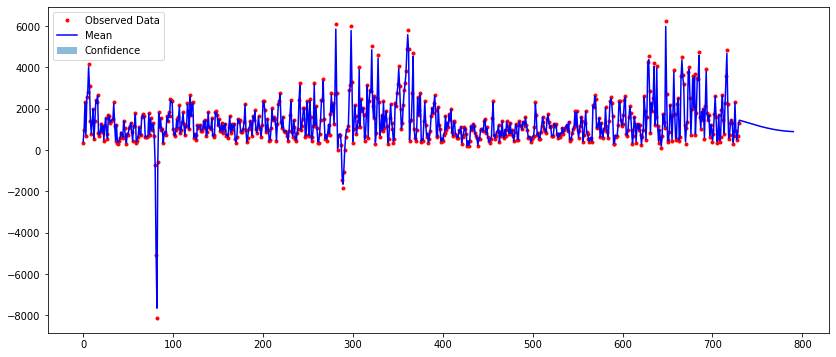

In [38]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(14, 6))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'r.')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

## 2. Analizar  correlaciones de presencia de valores faltantes en las diferentes estaciones. Generar visualizaciones y discutir

In [5]:
# columnas que representan los contaminantes
var_cont = ['PM2.5', 'PM10', 'SO2', 'NO2','CO', 'O3']

# ver porcentaje valores faltantes en estas columnas 
(data[var_cont].isnull().sum() / data.shape[0])*100
# Es en general a lo mas un 4.9% de datos perdidos

PM2.5    2.076916
PM10     1.532674
SO2      2.143937
NO2      2.879497
CO       4.919813
O3       3.155421
dtype: float64

In [31]:
# station_list = data['station'].unique()
# for station in station_list:
#     print(station, data[data['station'] == station]['delta_time'])

In [6]:
# ademas vemos los tipos de datos para ver si existen strings 
# o datos faltantes en otro formato
data[var_cont].info()
# como todos son del tipo float64, por lo que podemos seguir sin 
# hacer replace

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420768 entries, 0 to 420767
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   PM2.5   412029 non-null  float64
 1   PM10    414319 non-null  float64
 2   SO2     411747 non-null  float64
 3   NO2     408652 non-null  float64
 4   CO      400067 non-null  float64
 5   O3      407491 non-null  float64
dtypes: float64(6)
memory usage: 19.3 MB


In [15]:
# fig, ax = plt.subplots(figsize = [15, 10])
# msno.matrix(data[var_cont],ax = ax, sparkline=True)

### En la anterior visualización se puede notar que los valores faltantes
### se observa que los valores faltantes para PM10 tambien lo son para 
### el resto de los contaminantes, calculamos el porcentaje de filas para 
### las que esta observacion es cierta

In [7]:
# ver porcentaje valores faltantes las filas de valores faltantes
# de la columna PM10
(data[var_cont][data['PM10'].isnull()].isnull().sum() / 
 data[var_cont][data['PM10'].isnull()].shape[0])*100

PM2.5     96.650644
PM10     100.000000
SO2       80.942782
NO2       81.625058
CO        82.322841
O3        77.903551
dtype: float64

### Como el porcentaje es mayor a 80% en 4 de la 5 columnas
### podria eliminarse todas las filas con datos faltantes 
### asociados a PM10 con la siguiente celda, pero de rompería la 
### estructura de serie de tiempo.

In [37]:
# data = data[data['PM10'].isnull() == False].reset_index(drop=True)

## 3. En las columnas de contaminantes, rellene los valores faltantes mediante interpolacion. Pruebe diferentes metodos de interpolacion, seleccione un y fundamente su eleccion.

In [44]:
# data[var_cont] = data[var_cont].interpolate(method='quadratic')

In [11]:
# station_list = data['station'].unique()
# station = station_list[0]

# plt.plot(data[data['station'] == station]['delta_time'][:1000],
#          data[data['station'] == station]['PM2.5'][:1000], 'b-')

In [12]:
# metod_dict = {'linear': data[var_cont].interpolate(method='linear'),
#               'cubic': data[var_cont].interpolate(method='cubic'),
#               'nearest': data[var_cont].interpolate(method='nearest'),
#               'quadratic': data[var_cont].interpolate(method='quadratic')}

In [13]:
# station_list = data['station'].unique()

In [14]:
# plt.plot(data[data['station'] == station]['delta_time'][:1000],
#          data[data['station'] == station]['PM2.5'][:1000], 'b-')

In [15]:
# fig, ax = plt.subplots(figsize=[12,13])
# station = station_list[0]

# xnew = np.linspace(0, 4, 30)

# plt.plot(data[data['station'] == station]['delta_time'][:1000],
#          data[data['station'] == station]['PM2.5'][:1000], '.',
#          data[data['station'] == station]['delta_time'][:1000],
#          metod_dict['linear'][data['station'] == station]['PM2.5'][:1000], '-',
#          data[data['station'] == station]['delta_time'][:1000],
#          metod_dict['cubic'][data['station'] == station]['PM2.5'][:1000], '--',
#          data[data['station'] == station]['delta_time'][:1000],
#          metod_dict['nearest'][data['station'] == station]['PM2.5'][:1000], 'x',
#          data[data['station'] == station]['delta_time'][:1000],
#          metod_dict['quadratic'][data['station'] == station]['PM2.5'][:1000], 'o')

# plt.legend(['linear', 'cubic', 'nearest', 'quadratic'], loc = 'best')


# plt.show()

In [16]:
# data.columns

In [8]:
data[var_cont] = data[var_cont].interpolate(method='quadratic')

### Esperar respuesta de que significa probar con distintos y 
### revisar si cuadratic hace una regression cuadratica

In [9]:
(data.isnull().sum() / data.shape[0])*100

year          0.000000
month         0.000000
day           0.000000
hour          0.000000
PM2.5         0.000000
PM10          0.000000
SO2           0.000000
NO2           0.000000
CO            0.000000
O3            0.000000
TEMP          0.094589
PRES          0.093401
DEWP          0.095777
RAIN          0.092688
wd            0.433018
WSPM          0.075576
station       0.000000
delta_time    0.000000
dtype: float64

### en las restantes columnas el porcentaje de valores restantes
### es bajo (<0.1), excepto en la columna wd, por lo que se considera
### eliminar la columna wd y el resto de valores faltantes si es necesario

## 4. Analice las correlaciones para cada contaminantes en las diferentes estaciones. Genere visualizaciones, discuta lo observado y seleccione el contaminante que tenga el menor promedio de correlacion entre estaciones. Para dicho contaminante, seleccione las tres estaciones que tengan el promedio de correlacion mas alto.

### Se genera un heatmap de correlaciones para cada contaminante

In [10]:
station_list = data['station'].unique()
list_corr = [(pd.DataFrame({station: list(data[data['station']==station][contam]) 
                           for station in station_list})).corr() for contam in var_cont]

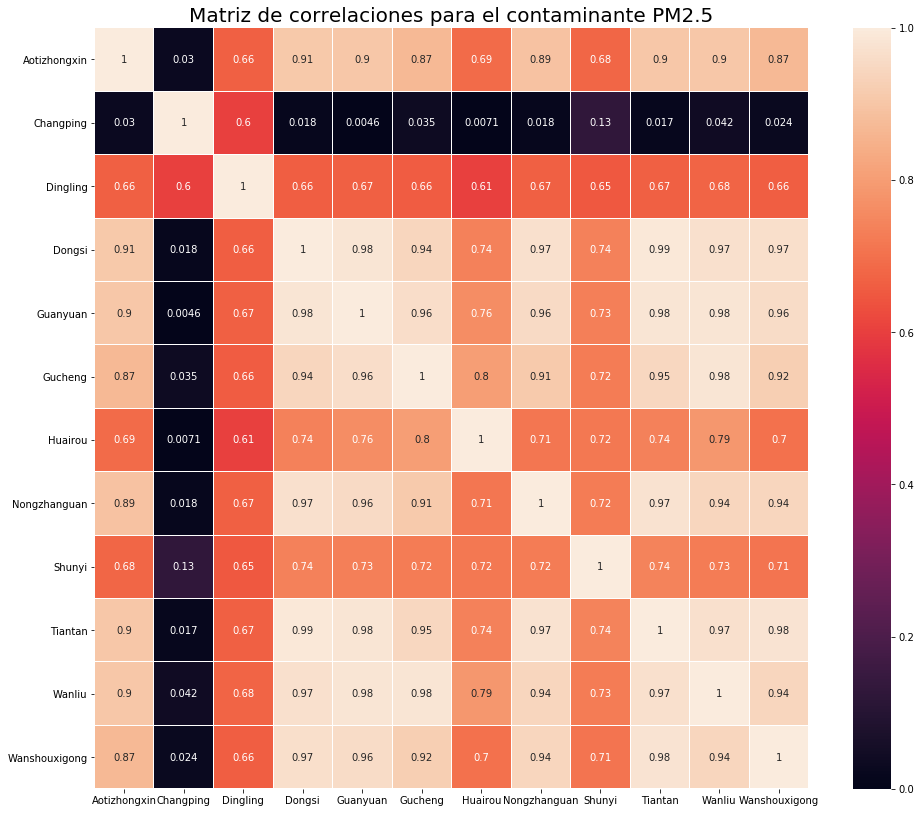

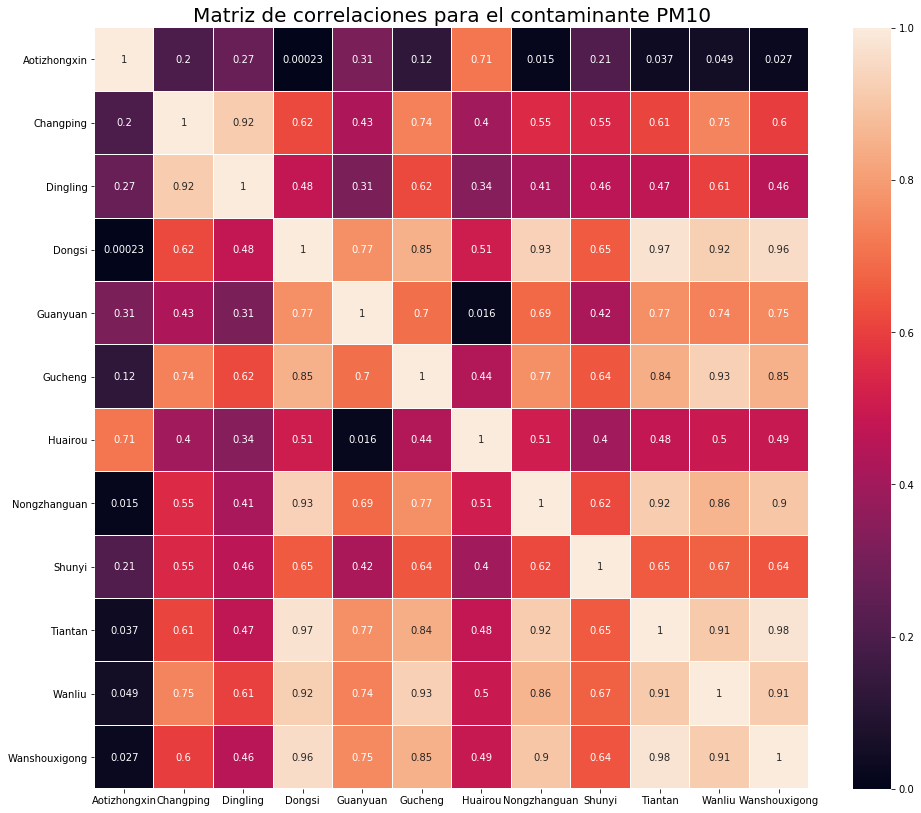

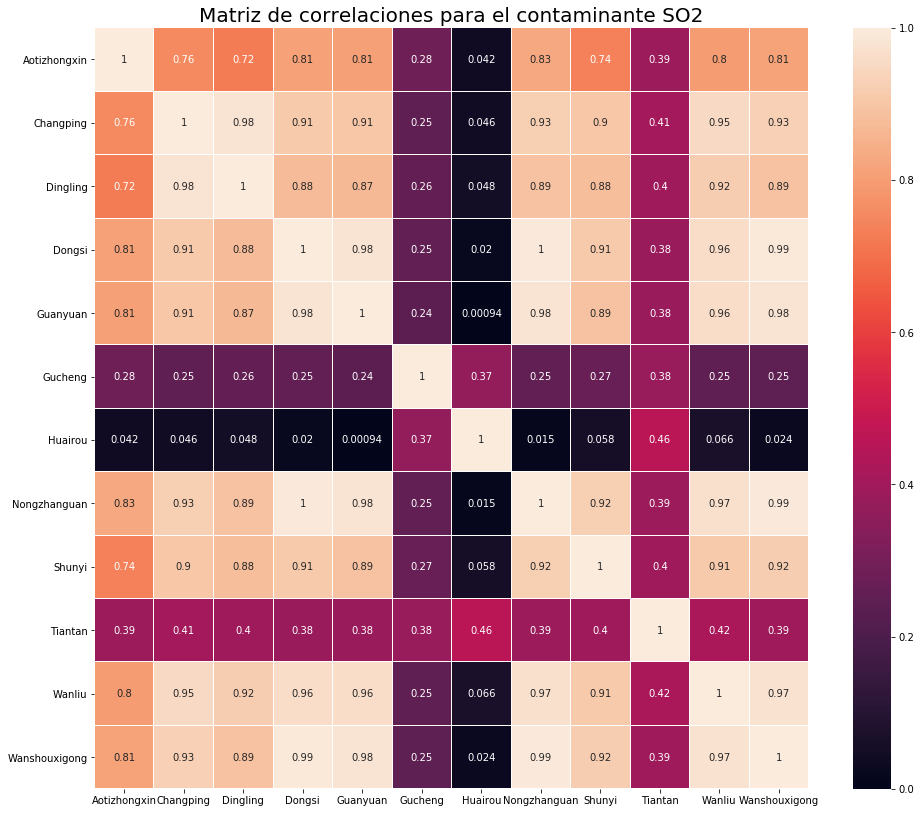

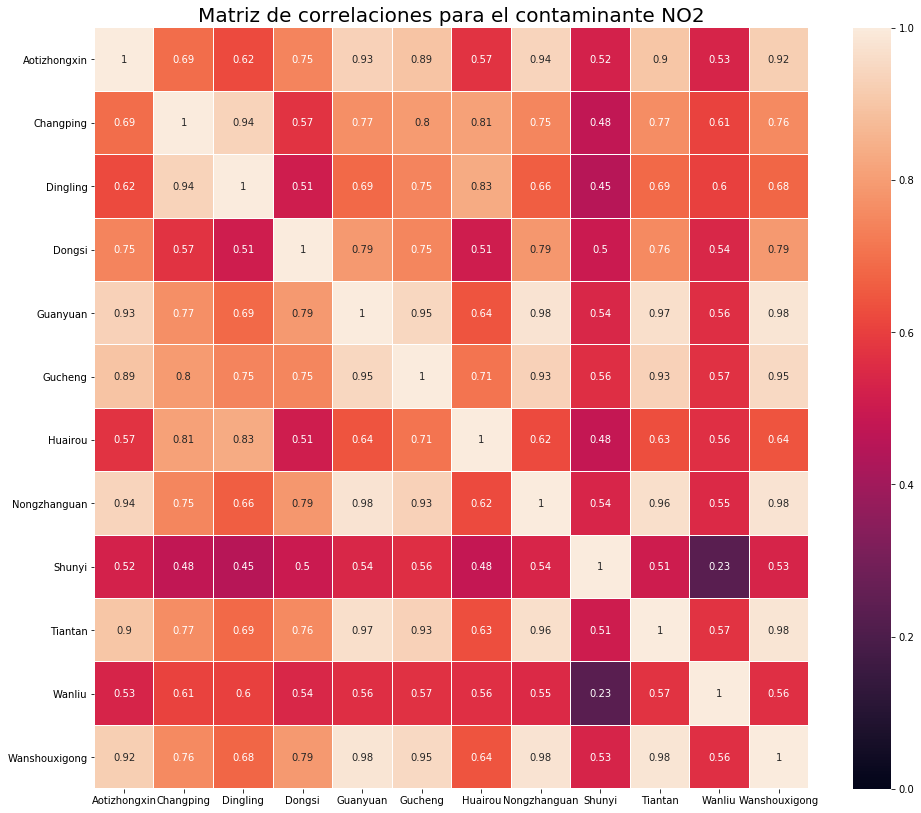

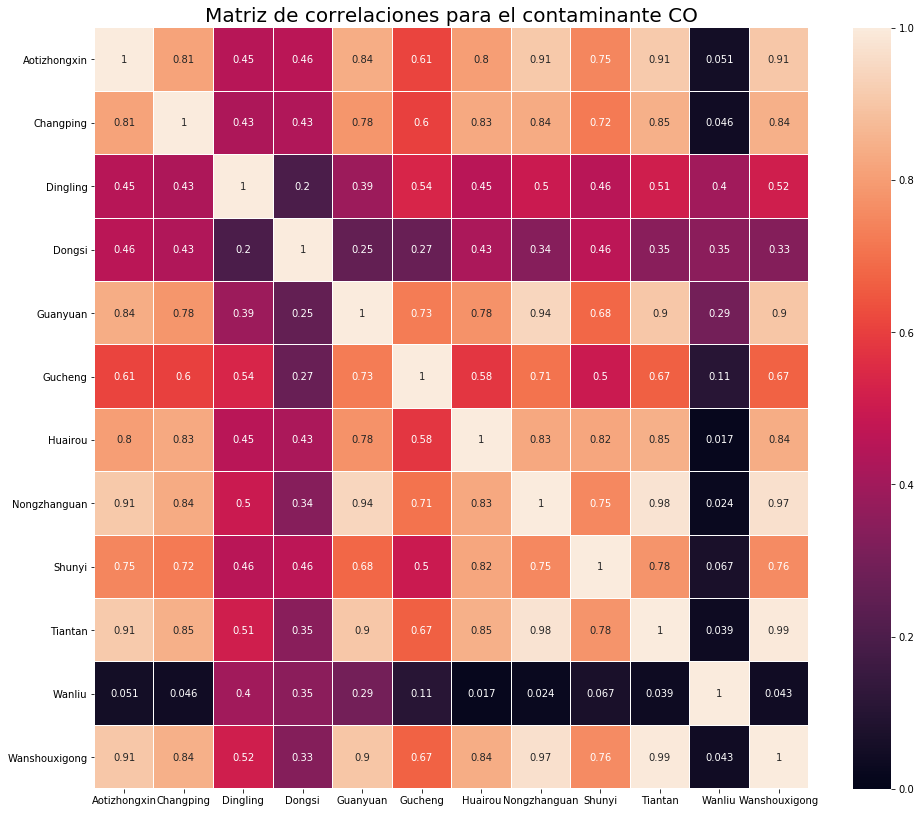

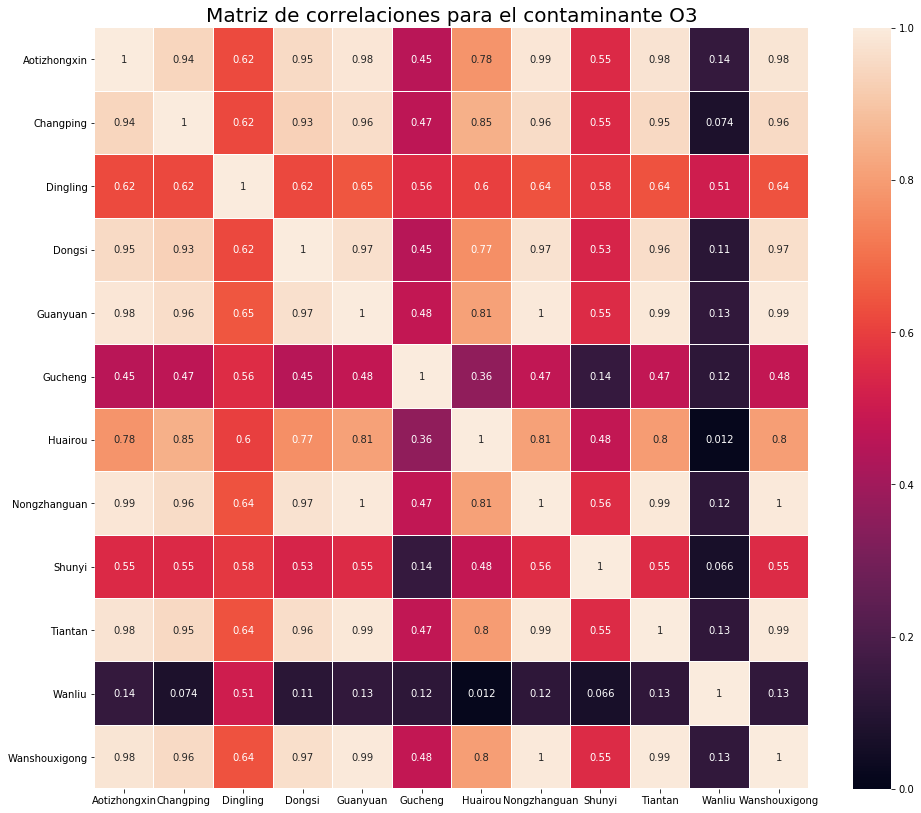

In [11]:
for i in range(len(list_corr)):
    corrmat = list_corr[i].corr()
    fig, ax = plt.subplots(figsize=[16, 14])
    ax.set_title('Matriz de correlaciones para el contaminante ' + var_cont[i],
                 fontdict={'fontsize': 20})
    sns.heatmap(abs(corrmat), vmin=0, vmax=1, linewidths=.01, annot=True)

### se observa que el contaminante SO2 una gran cantidad de colores 
### oscuros, por lo que se presume que tiene el menor promedio de 
### correlacion, se procede a calcular los promedios.

In [12]:
promedios = pd.Series({var_cont[i]:list_corr[i].mean().mean() for i in range(len(var_cont))})
promedios

PM2.5    0.734431
PM10     0.718758
SO2      0.573843
NO2      0.526677
CO       0.472495
O3       0.597334
dtype: float64

### Como fue observado, CO tiene el menor promedio de correlacion, ahora 
### se calculan las tres estaciones con el mayor promedio de correlación 

In [13]:
corrmat = list_corr[var_cont.index('CO')]
((corrmat.abs().sum()-1)/(len(corrmat)-1)).nlargest(3)

Tiantan          0.596162
Wanshouxigong    0.586291
Nongzhanguan     0.583003
dtype: float64

### Las estaciones elegidas fueron: Tiantan,  Wanshouxigong y Nongzhanguan

In [14]:
contam = 'CO'
choice_stations = ['Tiantan', 'Wanshouxigong', 'Nongzhanguan']

## 5. Descomponga en una tendencia, una señal periodica y su residuo; la señal del contaminante seleccionado en cada una de las 3 estaciones seleccionadas. Genere visualizaciones, discuta lo observado ademas de explicar el comportamiento de dicha funcion.

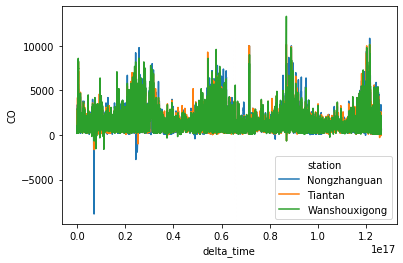

In [15]:
# Plot the responses for different events and regions
sns.lineplot(x='delta_time', y=contam,
             hue='station', data=data[(data['station'] == choice_stations[0])
                                      |(data['station'] == choice_stations[1])
                                      |(data['station'] == choice_stations[2])])

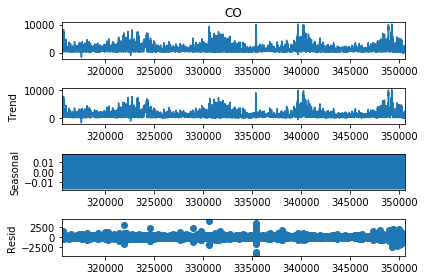

In [16]:
station_0 = seasonal_decompose(data[data['station']==choice_stations[0]]['CO'],
                               model='additive', period=2)
station_0.plot()
plt.show()

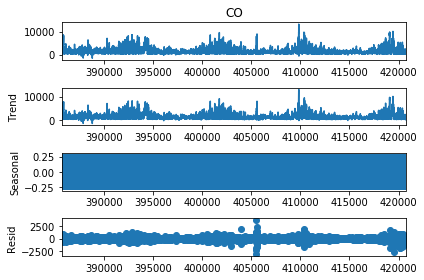

In [17]:
station_1 = seasonal_decompose(data[data['station']==choice_stations[1]]['CO'],
                               model='additive', period=2)
station_1.plot()
plt.show()

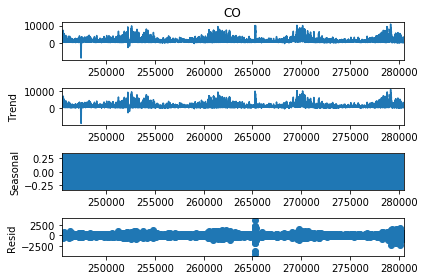

In [18]:
station_2 = seasonal_decompose(data[data['station']==choice_stations[2]]['CO'],
                               model='additive', period=2)
station_2.plot()
plt.show()

# P2. Modelacion

## Genere una agrupacion del conjunto de datos, donde se tenga disponibilidad de la concentracion diaria promedio del contaminante objetivo para cada estacion.

### Nuevo DataFrame con el contaminante y estaciones anteriormente elegidos

In [26]:
# filtrar columnas
columns = ['year', 'month', 'day', 'hour', 'CO', 'TEMP','PRES',
           'DEWP', 'RAIN', 'wd', 'WSPM', 'station', 'delta_time']
df = data[columns]
# filtrar estaciones
df = df[(df['station'] == choice_stations[0])|
        (df['station'] == choice_stations[1])|
        (df['station'] == choice_stations[2])]
# reset index
df.reset_index(drop=True, inplace=True)

In [28]:
# Guardar data frame y terminar la P2.1
# df.to_csv('Data_Gaussian_Process.xlsx')